## IMERG `Sequences`
* The aim of this notebook is to manually generate the IMERG eligible sequences and compare it to the `.py` output. 

* Plot the sequences to explore different pixel thresholds for importance sampling.

* This notebook is a precursor for the `process_data_sequences.py` and the subsequent shell script `process_raw_imerg_data.sh`

In [23]:
import datetime
import os
import re

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import io

from rainnow.src.configs.config import (
    PATCH_SIZE,
    IMERG_CROP,
    IMERGEarlyRunConfig,
)
from rainnow.src.configs.data_processing_configs import sequencing_config
from rainnow.src.data_prep.data_processing import (
    create_imerg_file_path_mapping,
    create_file_path,
    open_file_with_h5py_and_get_data,
    generate_list_of_sequences_from_file_mapping,
    get_available_sequences_from_file_mapping,
    load_imerg_h5_file_into_xarr,
    crop_xarr_using_lat_and_lon,
    patch_2d_arr_into_nxn_squares,
    create_file_path,
)
from rainnow.src.utilities.utils import calculate_required_1d_padding

#### `helpers.`

In [ ]:
# ** dir helpers **
BASE_PATH = "/teamspace/studios/this_studio"

# load in custom colour map.
cmap = io.loadmat(f"{BASE_PATH}/DYffcast/rainnow/src/utilities/cmaps/colormap.mat")
# cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
rain_cmap = ListedColormap(cmap["Cmap_rain"])
plot_params = {"cmap": rain_cmap, "vmin": 1, "vmax": 8, "origin": "upper"}
global_params = {"font.size": 12, "font.family": "Times New Roman"}

In [24]:
# get configs.
imerg_config = IMERGEarlyRunConfig()

config = sequencing_config
config

{'sequence_length': 4,
 'horizon': 1,
 'dt': 2,
 'stride': 5,
 'pixel_threshold': 0.1,
 'file_suffix': '_cropped_128_patched',
 'file_type': '.h5',
 'logs': 'logs/data_sequencing',
 'download_dir': '/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER',
 'patch_size': 128}

In [25]:
start_time = datetime.datetime.strptime("2020-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
end_time = datetime.datetime.strptime("2020-02-01 00:00:00", "%Y-%m-%d %H:%M:%S")

print(f"*** running sequences for time window: {start_time} - {end_time} ***")

# create IMERG file mapping.
file_mapping = create_imerg_file_path_mapping(
    start_time=start_time, end_time=end_time, imerg_config=imerg_config
)

*** running sequences for time window: 2020-01-01 00:00:00 - 2020-02-01 00:00:00 ***


In [26]:
list_sequences = generate_list_of_sequences_from_file_mapping(
    file_mapping=file_mapping,
    sequence_length=config["sequence_length"],
    horizon=config["horizon"],
    dt=config["dt"],  # undersampling if > 1.
    stride=config["stride"],
)
len(list_sequences)

148

In [27]:
list_sequences[0]

['202001010000',
 '202001010060',
 '202001010120',
 '202001010180',
 '202001010240']

In [28]:
available, unavailable = get_available_sequences_from_file_mapping(
    list_sequences=list_sequences, file_mapping=file_mapping, config=config
)
len(available), len(unavailable)

(148, 0)

### `CODE TO DELETE FILES.`

In [29]:
# files_to_delete = []
# suffix_to_delete = "_cropped_patched.h5"
# for k, v in file_mapping.items():
#     file_path = os.path.join(DOWNLOAD_DIR, GPM_API_DOWNLOAD_DIR_STRUCTURE, f"{v}{suffix_to_delete}")
#     if os.path.exists(file_path):
#         files_to_delete.append(file_path)

# for i in files_to_delete:
#     print(f"removing {i}")
#     # os.remove(i)

In [34]:
i, j = 2, 0

print(f"*** using (i, j) --> ({i}, {j}) ***")

*** using (i, j) --> (2, 0) ***


### `non-parallel`

In [35]:
list_eligible_sequences, list_not_eligible_sequences = [], []
for e, sequence in enumerate(available):
    file_paths = [
        create_file_path(
            data_dir=config["download_dir"],
            file_name=file_mapping[tile],
            file_suffix=config["file_suffix"],
            file_type=config["file_type"],
        )
        for tile in sequence
    ]

    arrays = np.stack([open_file_with_h5py_and_get_data(file_path) for file_path in file_paths])
    max_avg = np.max(
        np.mean(arrays[:, i, j, :, :], axis=(1, 2)),
        axis=0,
    )
    if max_avg >= config["pixel_threshold"]:
        list_eligible_sequences.append(sequence)
    else:
        list_not_eligible_sequences.append(sequence)

len(list_eligible_sequences), len(list_not_eligible_sequences)

(42, 106)

### `LOAD IN .CSV generated via PARALLEL` and compare it to the explicitly generated sequences...

In [16]:
folder_name = "2023-01-01_2023-04-01_i1_j0_s4_h1_dt2_str5_thr0.1_PS_128"

df = pd.read_csv(
    f"../src/data_prep/sequences/{folder_name}/eligible_{folder_name}.csv",
    header=None,
)
print(f"raw df length = {len(df)}")

# can subset if you are interested in certain dates.
# cyclone YUKA is start of march 2023.
dt_min = "202303010000"
dt_max = "202304010000"
df_subset = df[(df[0].astype(int) >= int(dt_min)) & (df[0].astype(int) <= int(dt_max))]
print(f"subsetted df length = {len(df_subset)}")

raw df length = 394
subsetted df length = 145


In [17]:
df.values.astype(str).tolist() == list_eligible_sequences

True

In [18]:
df_subset.head()

,0,1,2,3,4
249,202303010240,202303010300,202303010360,202303010420,202303010480
250,202303010540,202303010600,202303010660,202303010720,202303010780
251,202303010840,202303010900,202303010960,202303011020,202303011080
252,202303011140,202303011200,202303011260,202303011320,202303011380
253,202303020000,202303020060,202303020120,202303020180,202303020240


#### `Plotting sequences`

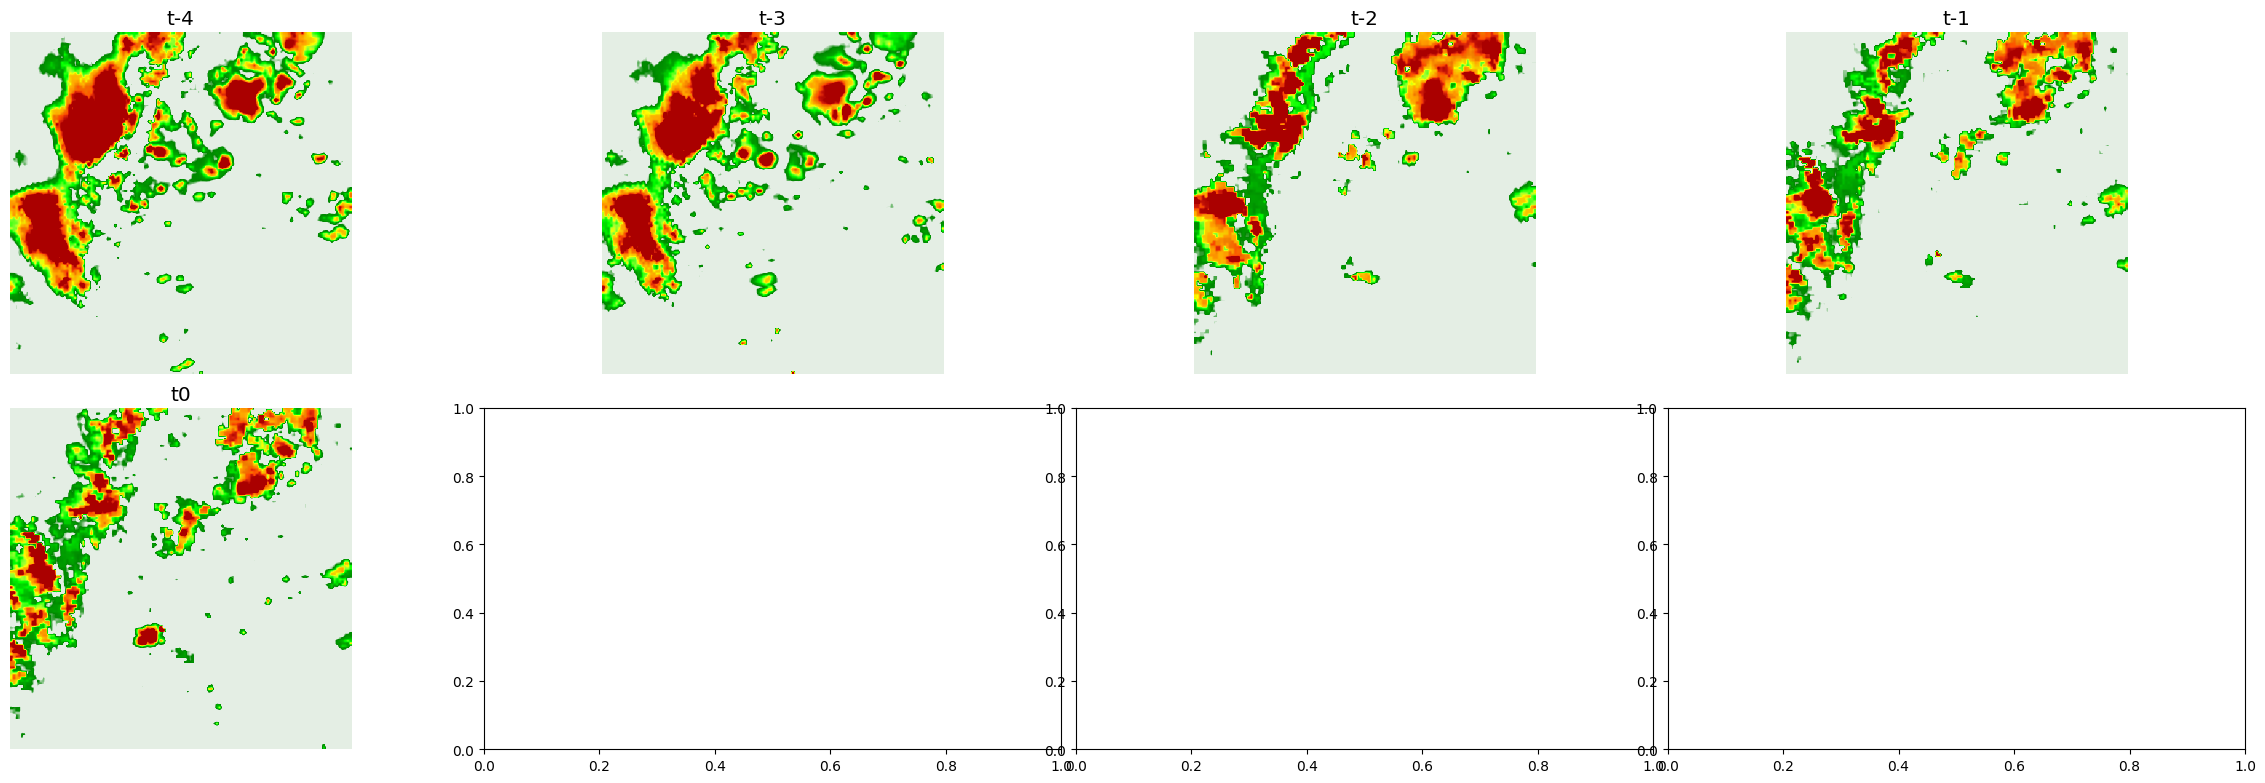

In [22]:
seq_len = config["sequence_length"]
h = config["horizon"]

_i = 289
_idx = min(_i, len(df) - 1)
sequence = df.iloc[_idx].astype(str).to_list()

fig, axs = plt.subplots(nrows=2, ncols=seq_len, figsize=(24, 8))
plt.rcParams.update(global_params)
_pre_sequence = []
for _row in range(2):
    for _col in range(seq_len if _row == 0 else len(sequence) - seq_len):
        idx = _col + (_row * seq_len)
        if idx < len(sequence):
            file_path = create_file_path(
                data_dir=config["download_dir"],
                file_name=file_mapping[sequence[idx]],
                file_suffix=config["file_suffix"],
                file_type=config["file_type"],
            )
            _data = open_file_with_h5py_and_get_data(file_path)
            _data_i_j = _data[i, j, :, :]
            _pre_sequence.append(_data_i_j)
            axs[_row, _col].imshow(_data_i_j, **plot_params)
            axs[_row, _col].set_title(f"t{idx - seq_len}")
            axs[_row, _col].axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0.025, hspace=0.1)

### `SEQUENCE CHECKER`

In [ ]:
sequence

['202303090720',
 '202303090780',
 '202303090840',
 '202303090900',
 '202303090960']

In [ ]:
_raw_sequence = []
for timeslice in sequence:
    # get file paths.
    raw_file_path = create_file_path(
        data_dir=config["download_dir"],
        file_name=file_mapping[timeslice],
        file_suffix="",
        file_type=".RT-H5",
    )

    print(raw_file_path)

    raw_arr = load_imerg_h5_file_into_xarr(file_path=raw_file_path)
    cropped_arr = crop_xarr_using_lat_and_lon(
        xarr=raw_arr,
        lat_lims=IMERG_CROP["inner"]["latitude"],
        lon_lims=IMERG_CROP["inner"]["longitude"],
    )
    y_max, x_max = cropped_arr.shape  # opposite due to (lat, lon).
    x_pad = calculate_required_1d_padding(X=x_max, Y=PATCH_SIZE, frac=0)
    y_pad = calculate_required_1d_padding(X=y_max, Y=PATCH_SIZE, frac=0)
    patched_arr = patch_2d_arr_into_nxn_squares(
        arr2d=cropped_arr,
        n=PATCH_SIZE,
        x_pad=x_pad,
        y_pad=y_pad,
        flip_pixels=True,
    )

    _raw_sequence.append(patched_arr[i, j, :, :])

    # _raw_sequence.append(patched_arr[config["grid_i"], config["grid_j"], :, :])

# # check that the sequences match.
# np.all(
#     [np.allclose(_pre_sequence[i], _raw_sequence[i]) for i in range(len(_pre_sequence))]
# )

/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/2023/03/09/3B-HHR-E.MS.MRG.3IMERG.20230309-S120000-E122959.0720.V07B.RT-H5
/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/2023/03/09/3B-HHR-E.MS.MRG.3IMERG.20230309-S130000-E132959.0780.V07B.RT-H5
/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/2023/03/09/3B-HHR-E.MS.MRG.3IMERG.20230309-S140000-E142959.0840.V07B.RT-H5
/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/2023/03/09/3B-HHR-E.MS.MRG.3IMERG.20230309-S150000-E152959.0900.V07B.RT-H5
/Volumes/external_disk_seal/data/GPM/NRT/IMERG/IMERG-ER/2023/03/09/3B-HHR-E.MS.MRG.3IMERG.20230309-S160000-E162959.0960.V07B.RT-H5


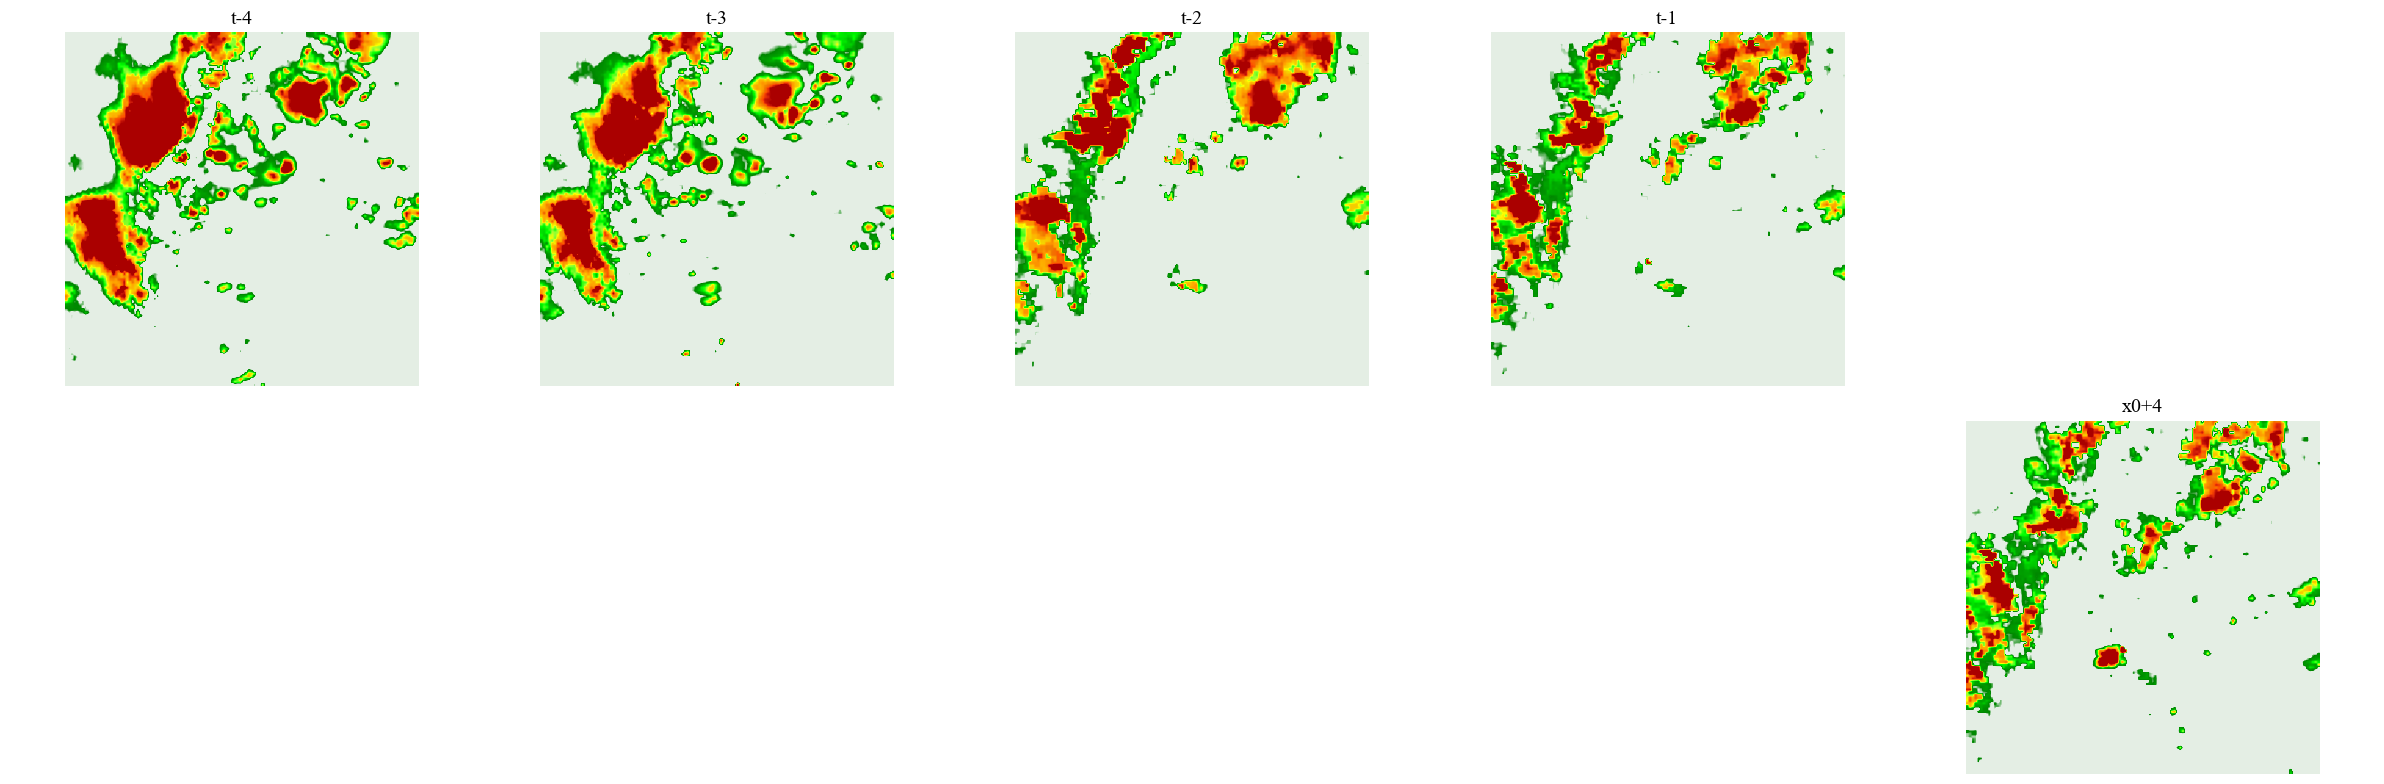

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=seq_len + config["horizon"], figsize=(24, 8))
plt.rcParams.update(global_params)


for _col in range(seq_len + config["horizon"]):
    if _col < seq_len:
        axs[0, _col].imshow(_raw_sequence[_col], **plot_params)
        axs[0, _col].set_title(f"t{_col - seq_len}")
        axs[0, _col].axis("off")

    else:
        # plot target.
        axs[1, _col].imshow(_raw_sequence[idx], **plot_params)
        axs[1, _col].set_title(f"x0+{_col}")

    axs[0, _col].axis("off")
    axs[1, _col].axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0.025, hspace=0.1)

### `Check the sequences against step-by-step.` 

In [ ]:
for sequence in list_eligible_sequences:
    print(f"Checking sequence: {sequence}")
    for tile in sequence:
        # get file paths.
        raw_file_path = create_imerg_file_path(
            key=tile, file_mapping=file_mapping, file_suffix="", file_type=".RT-H5"
        )

        cropped_patched_file_path = create_imerg_file_path(
            key=tile, file_mapping=file_mapping, file_suffix="_cropped_patched", file_type=".nc"
        )
        # crop and patch raw tile.
        raw_imerg_cropped_tile = create_xarr_from_imerg_hdf5(
            path_to_hdf5=raw_file_path, lat_lims=IMERG_CROP["latitude"], lon_lims=IMERG_CROP["longitude"]
        )
        y_max, x_max = raw_imerg_cropped_tile.shape
        x_pad = calculate_required_1d_padding(X=x_max, Y=PATCH_SIZE, frac=1)
        y_pad = calculate_required_1d_padding(X=y_max, Y=PATCH_SIZE, frac=1)
        patched_raw_tile = create_square_patches_from_2d_arr_using_overlap(
            arr2d=raw_imerg_cropped_tile,
            patch_size=PATCH_SIZE,
            x_pad=x_pad,
            y_pad=y_pad,
            flip_pixels=True,
        )

        # get pre-cropped & pre-cropped-patched tile.
        cropped_patched_tile = open_nc_file(file_path=cropped_patched_file_path)
        # check that the patched cropped raw imerg tile = pre-cropped-patched tile.
        assert np.allclose(patched_raw_tile, cropped_patched_tile)

### END OF SCRIPT.